This notebook was made to compare more drifter-model results, with new river channel, reduced viscosty, no_banks and reduced viscosity&old river as well as vertical profiles at some grid points during flood tide.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import datetime as dt
import pytz, datetime
import scipy.io
import arrow
import os
from IPython.core.display import Image
from salishsea_tools import nc_tools, viz_tools, tidetools, stormtools, bathy_tools
from __future__ import division

In [2]:
grid = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc','r')
bathy, X, Y = tidetools.get_bathy_data(grid)
lats = grid.variables['nav_lat']
lons = grid.variables['nav_lon']
bath = grid.variables['Bathymetry']

In [3]:
tracersT = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_10RFdailySmoo/\
SalishSea_1h_20141008_20141010_grid_T.nc')
nc_tools.show_variables(tracersT)
ssh = tracersT.variables['sossheig']
timesteps = tracersT.variables['time_counter']
nc_tools.timestamp(tracersT, 0)

[u'deptht', u'nav_lat', u'nav_lon', u'rain_rate', u'snow_rate', u'sossheig', u'time_counter', u'time_counter_bnds', u'vosaline', u'votemper']


<Arrow [2014-10-08T00:30:00+00:00]>

In [4]:
def plotoct_mewold(lon,lat,part,start,end,start_d,end_d,day,hour,minute,duration):
    fig, axs = plt.subplots(2, 2, figsize=(11, 10))
    viz_tools.plot_coastline(axs[0,0],grid,coords='map')
    viz_tools.plot_coastline(axs[0,0],grid,coords='map',isobath=4,color='FireBrick')
    viz_tools.plot_coastline(axs[0,0],grid,coords='map',isobath=20,color='OrangeRed')
    axs[0,0].set_xlim([-123.6,-123])
    axs[0,0].set_ylim([48.8,49.4])
    axs[0,0].set_xticks([-123.6, -123.4, -123.2,-123])
    axs[0,0].set_xticklabels([-123.6, -123.4, -123.2,-123])
    axs[0,0].set_xlabel('Longitude')
    axs[0,0].set_ylabel('Latitude')
    
    colors=['g','DodgerBlue','tomato','Olive']
    for i, key in enumerate(lon.keys()):
        axs[0,0].scatter(lon[key][1:,part],lat[key][1:,part],marker='o',color=colors[i],label=key)
        axs[0,0].scatter(lon[key][0,part],lat[key][0,part],color='0.30',marker='s')
    axs[0,0].plot(-123-np.array([18.2,13.7,12])/60.,49+np.array([6.4,8,7.6])/60.,'-k',lw=2,color='Indigo')
    axs[0,0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),
          ncol=5, fancybox=False, shadow=True)
    
    axs[0,1].plot(timesteps[0:48],ssh[0:48,466,329],'-k')
    
    axs[0,1].set_xticklabels([])
    axs[0,1].set_ylabel('Water level (m)')
    axs[0,1].set_xlabel('Oct 8 - Oct 9 (hrs)')
    axs[0,1].set_title('sossheig, ~Point Atkinson')
        
    t=hour
    axs[0,1].plot([timesteps[t],timesteps[t]],[-2.0,1.5],'r-',label='start')
    
    t2=hour+duration
    axs[0,1].plot([timesteps[t2],timesteps[t2]],[-2.0,1.5],'b-',label='end')
    
    [wind_speed,wind_dir,temp,time, lat, lon] = stormtools.get_EC_observations('Sandheads',start,end)   
    #fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(11, 5))
    axs[1,0].plot(time,wind_speed,'-k')
    axs[1,0].set_xlim(dt.datetime(2014,10,start_d),dt.datetime(2014,10,end_d))
    axs[1,0].set_xticklabels([])
    axs[1,0].set_xlabel('Oct 8 - Oct 9 (hrs)')
    axs[1,0].set_ylabel('Wind Speed (m/s)')
    axs[1,0].set_title('Sandheads')
    
    diff = 24 - hour
    hour2 = duration - diff
    day2 = day +1
    
    t=dt.datetime(2014,10,day,hour,minute)
    axs[1,0].plot([t,t],[0,10],'r-',label='start')
    tt=dt.datetime(2014,10,day2,hour2,minute)
    axs[1,0].plot([tt,tt],[0,10],'b-',label='end')
    axs[1,0].legend(loc='upper left')

    axs[1,1].plot(time,wind_dir,'-k')
    axs[1,1].set_xlim(dt.datetime(2014,10,start_d),dt.datetime(2014,10,end_d))
    axs[1,1].set_xticklabels([])
    axs[1,1].set_xlabel('Oct 8 - Oct 9 (hrs)')
    axs[1,1].set_ylabel('Wind Direction (deg CCW of E)')
    axs[1,1].set_title('Sandheads')
    
    t=dt.datetime(2014,10,day,hour,minute)
    axs[1,1].plot([t,t],[0,350],'r-',label='start')
    tt=dt.datetime(2014,10,day2,hour2,minute)
    axs[1,1].plot([tt,tt],[0,350],'b-',label='end')
    axs[1,1].legend(loc='upper left')
    return fig

In [5]:
directories = ['oct8_10RFdailySmoo', 'oct8_10reduceviscosity','oct8_101e061e05','4-10oct14']
bases = ['/data/jieliu/MEOPAR/river-treatment/','/data/dlatorne/MEOPAR/SalishSea/nowcast/early-days/']
sfile_pattern = ['{}/SalishSea_1h_20141008_20141010_grid_T.nc','{}/SalishSea_1h_20141004_20141010_grid_T.nc']
ufile_pattern = ['{}/SalishSea_1h_20141008_20141010_grid_U.nc','{}/SalishSea_1h_20141004_20141010_grid_U.nc']
vfile_pattern = ['{}/SalishSea_1h_20141008_20141010_grid_V.nc', '{}/SalishSea_1h_20141004_20141010_grid_V.nc']
Ss={};Us={};Vs={};depths={};
##load non-nowcasts results
for directory in directories: 
    if directory == directories[-1]:
        path = os.path.join(bases[1],sfile_pattern[1].format(directory))
        f = nc.Dataset(path,'r');
        Ss[directory] = f.variables['vosaline']
        depths[directory] = f.variables['deptht'] 
        path = os.path.join(bases[1],ufile_pattern[1].format(directory))
        f = nc.Dataset(path,'r');
        Us[directory] = f.variables['vozocrtx']
        path = os.path.join(bases[1],vfile_pattern[1].format(directory))
        f = nc.Dataset(path,'r');
        Vs[directory] = f.variables['vomecrty']
    else:
        print('non-nowcast')
        path = os.path.join(bases[0],sfile_pattern[0].format(directory))
        f = nc.Dataset(path,'r');
        Ss[directory] = f.variables['vosaline']
        depths[directory] = f.variables['deptht']
        path = os.path.join(bases[0],ufile_pattern[0].format(directory))
        f = nc.Dataset(path,'r');
        Us[directory] = f.variables['vozocrtx']
        path = os.path.join(bases[0],vfile_pattern[0].format(directory))
        f = nc.Dataset(path,'r');
        Vs[directory] = f.variables['vomecrty']   

non-nowcast
non-nowcast
non-nowcast


In [6]:
def plot_salinity_uv(j,i,t, zmin,zmax):
    """This function was made to plot salinity, u, v profiles at the
       released position.    """
    fig, axs =plt.subplots(1,3, figsize = (15,6))
    colors=['g','Olive','DodgerBlue','tomato']
    ##salinity profiles
    ax = axs[0]
    for directory, c in zip(directories,colors):
        if (directory ==directories[-1]) & (c ==colors[-1]):
            ax.plot( Ss[directory][t+96,:,j,i],depths[directory],'--',\
                    linewidth = 2,color=c,label = directory)
        else:
            ax.plot( Ss[directory][t,:,j,i],depths[directory],'--',\
                    linewidth = 2,color=c,label = directory)
    ax.set_xlabel('Practical Salinity')
    ax.set_xlim([0,32])
    ##U profiles
    ax = axs[1]
    for directory, c in zip(directories,colors):
        if (directory ==directories[-1]) & (c ==colors[-1]):
            ax.plot( Us[directory][t+96,:,j,i],depths[directory],'--',\
                    linewidth = 2,color=c,label = directory)
        else:
            ax.plot( Us[directory][t,:,j,i],depths[directory],'--',\
                    linewidth = 2,color=c,label = directory)
    ax.set_xlabel('U velocity [m/s]')
    ax.set_xlim([-0.8,0.8])
    ##V profiles
    ax = axs[2]
    for directory, c in zip(directories,colors):
        if (directory ==directories[-1]) & (c ==colors[-1]):
            ax.plot( Vs[directory][t+96,:,j,i],depths[directory],'--',\
                    linewidth = 2,color=c,label = directory)
        else:
            ax.plot( Vs[directory][t,:,j,i],depths[directory],'--',\
                    linewidth = 2,color=c,label = directory)
    ax.set_xlabel('V velocity [m/s]')
    ax.set_xlim([-0.8,0.8])
    for ax in axs:
        ax.legend(loc = 'lower left')
        ax.set_ylabel('Depth [m]')
        ax.set_ylim([zmax,zmin])
        ax.grid('on')
    return fig

# Prepare for drifters to select single point along its track

In [7]:
drifters = scipy.io.loadmat('/ocean/mhalvers/research/drifters/SoG_drifters.mat',squeeze_me=True)
ubc = drifters['ubc']

In [8]:
def convert_time(matlab_time_array):
    "converts a matlab time array to python format"
    python_time_array=[]
    for t in matlab_time_array:
        python_datetime = dt.datetime.fromordinal(int(t)) + dt.timedelta(days=t%1) - dt.timedelta(days = 366)
        python_time_array.append(python_datetime)
    
    python_time_array = np.array(python_time_array)
    return python_time_array

In [9]:
def get_tracks(switch,lats,lons,ptime,in_water):
    """returns a list of tracks of each buoy, ie a trajectory for
    each time the buoy was released into the water"""
    all_tracks=[]
    for ind in switch:
        track_on = 1
        i = ind
        track ={'time':[], 'lat':[],'lon':[]}
        while(track_on):
            if in_water[i]!=1:
                track_on=0
            elif i==np.shape(in_water)[0]-1:    
                track['time'].append(ptime[i])
                track['lat'].append(lats[i])
                track['lon'].append(lons[i])
                track_on=0
            else:
                track['time'].append(ptime[i])
                track['lat'].append(lats[i])
                track['lon'].append(lons[i])
            i=i+1
        all_tracks.append(track)
        
    return all_tracks

In [10]:
def organize_info(buoy,btype):
    """ organizes the buoy info. Groups the buoy data into tracks for 
        when it was released into the water. """
    #creat arrays for easier access
    buoy_name = btype[buoy][0]
    lats = btype[buoy]['lat'].flatten()
    lons = btype[buoy]['lon'].flatten()
    mtime = btype[buoy]['mtime']
    in_water = btype[buoy]['isSub'].flatten()
    #convert mtime to python datetimes
    ptime = convert_time(mtime)
    
    #loop through in_water flag to find when buoy switched from being out of water to being in water. 
    switch = []; 
    for ind in np.arange(1,in_water.shape[0]):
        if int(in_water[ind]) != int(in_water[ind-1]):
            if int(in_water[ind])==1:
                switch.append(ind)
    
    all_tracks=get_tracks(switch,lats,lons,ptime.flatten(),in_water)
    
    return buoy_name, all_tracks

In [11]:
def print_info(buoy,btype):
    """ prints the release time, lat, lon, and duration of a buoy track"""
    name, tracks=organize_info(buoy,btype)
    print name
    print 'Release times, positions and duration in hours'
    for t in tracks:
        print t['time'][0], t['lat'][0], t['lon'][0],\
        (t['time'][-1]-t['time'][0]).total_seconds()/3600

In [12]:
def find_start(tracks, start_date):
    """returns the a list of indices for a track released on start date.
    Only checks the month and day of the start day"""
    i=0
    ind=[]
    starttimes=[]
    for t in tracks:   
        if int(t['time'][0].month) == start_date.month:
                if int(t['time'][0].day) == start_date.day:
                    ind.append(i)
        i=i+1
        
    return ind

In [13]:
def plot_buoy_random(tracks, startdate, day, hour,i=0, fancy=False):
    """ plots a buoy trajectory at the given startdate in an axis, ax.
    returns the trajectory that was plotted.
    The first track released on the startdate is plotted.
    For trajectories that were released mulitples times a day, i selects which release is plotted.
    """
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
    
    ind =find_start(tracks,startdate)
    traj=tracks[ind[i]]
    duration = (traj['time'][-1]-traj['time'][0]).total_seconds()/3600
    random_time = dt.datetime(2014, 10, day, hour)
    lonn = []
    latt = []

    print 'Released', traj['time'][0], 'at', traj['lat'][0], ',' , traj['lon'][0], 'for' , duration, 'hours'
    ax1.plot(traj['lon'],traj['lat'],'ob')
    ax1.plot(traj['lon'][0],traj['lat'][0],'sr')
    ax1.set_xlim([-123.6,-123])
    ax1.set_ylim([48.8,49.4])
    ax1.set_xticks([-123.6, -123.4, -123.2,-123])
    ax1.set_xticklabels([-123.6, -123.4, -123.2,-123])
    ax1.set_title('Observed Drift Track')
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude')
    for ii in np.arange(len(traj['time'])):
        if dt.timedelta(hours=0)<(traj['time'][ii] - random_time) < dt.timedelta(hours = 1):
            ax1.plot(traj['lon'][ii], traj['lat'][ii], '*r')
            lonn.append(traj['lon'][ii])
            latt.append(traj['lat'][ii])
            if traj['time'][ii].minute ==30:
                print (traj['time'][ii], traj['lon'][ii], traj['lat'][ii])
                [jjj, iii] = tidetools.find_closest_model_point\
                (float(traj['lon'][ii]),float(traj['lat'][ii]),X,Y,bathy)
    
    [j,i]=tidetools.find_closest_model_point(float(traj['lon'][0]),float(traj['lat'][0]),X,Y,bathy)
    ax1.plot(-123-np.array([18.2, 13.7, 12])/60.,49+np.array([6.4, 8, 7.6])/60.,'-k',lw=2); 
    if fancy:
        cmap = plt.get_cmap('winter_r')
        cmap.set_bad('burlywood')
        ax1.pcolormesh(X, Y, bathy, cmap=cmap)
        ax1.text(-123.15,49.13, "Fraser River", fontsize=12)
    else:
        viz_tools.plot_coastline(ax1, grid, coords='map')
        viz_tools.plot_coastline(ax1, grid, coords='map',isobath=4)
        viz_tools.plot_coastline(ax1, grid, coords='map',isobath=20)
        print 'Random lat & lon in NEMO coords:', jjj, iii
          
    ax2.plot(timesteps[0:48],ssh[0:48,466,329],'-k')
    
    ax2.set_xticklabels([])
    ax2.set_ylabel('Water level (m)')
    ax2.set_xlabel('Oct 8 - Oct 9 (hrs)')
    ax2.set_title('sossheig, ~Point Atkinson')
        
    t=hour
    ax2.plot([timesteps[t],timesteps[t]],[-2.0,1.5],'y-')
    
    return traj, jjj, iii, hour

# Comparison with extended and deepened river channel

* Oct8 drop1

In [14]:
lon112={};lat112={}
o112 = nc.Dataset('/ocean/jieliu/research/meopar/Ariane/result/oct8_10RFdailySmoo/drop1/\
12/ariane_trajectories_qualitative.nc','r')
lon112['new']=o112.variables['traj_lon']
lat112['new']=o112.variables['traj_lat']
o112 = nc.Dataset('/ocean/jieliu/research/meopar/Ariane/result/oct8_10reduceviscosity/drop1/\
12/ariane_trajectories_qualitative.nc','r')
lon112['reduce_viscosity']=o112.variables['traj_lon']
lat112['reduce_viscosity']=o112.variables['traj_lat']
o112 = nc.Dataset('/ocean/jieliu/research/meopar/Ariane/result/oct8_101e061e05/drop1/\
12/ariane_trajectories_qualitative.nc','r')
lon112['reduce_vis&diff']=o112.variables['traj_lon']
lat112['reduce_vis&diff']=o112.variables['traj_lat']
o112 = nc.Dataset('/ocean/nsoontie/MEOPAR/Ariane/results/drifters/oct8/drop1/\
12/ariane_trajectories_qualitative.nc','r')
lon112['old']=o112.variables['traj_lon']
lat112['old']=o112.variables['traj_lat']

Released 2014-10-08 16:10:07.000003 at 49.1054983333 , -123.319833333 for 28.7502777783 hours
(datetime.datetime(2014, 10, 8, 22, 30, 9, 1), -123.47508833333333, 49.101958333333336)
Random lat & lon in NEMO coords: 439 267


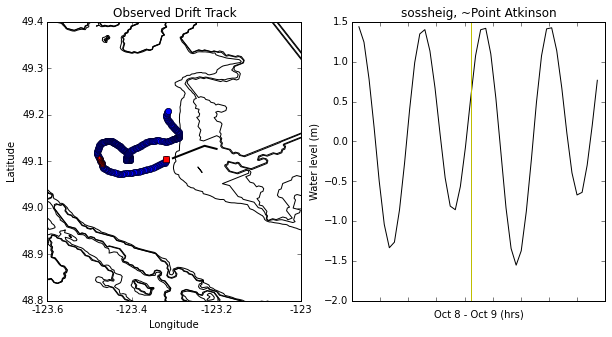

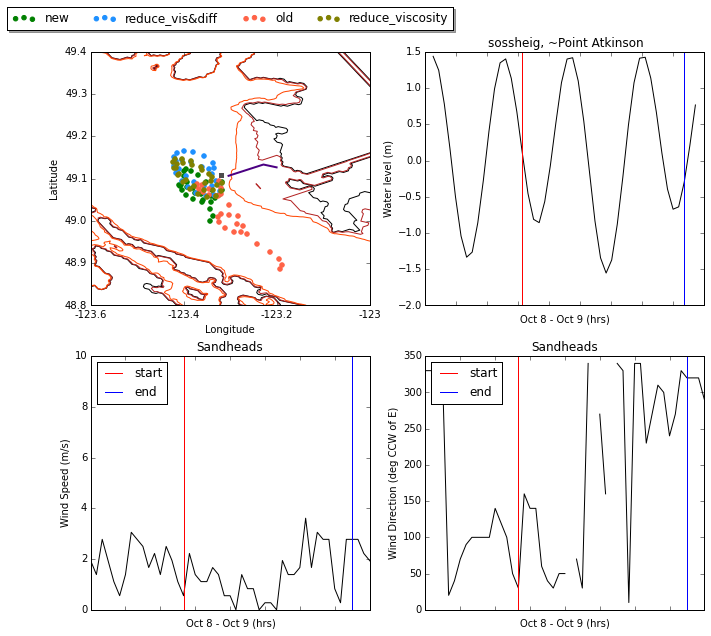

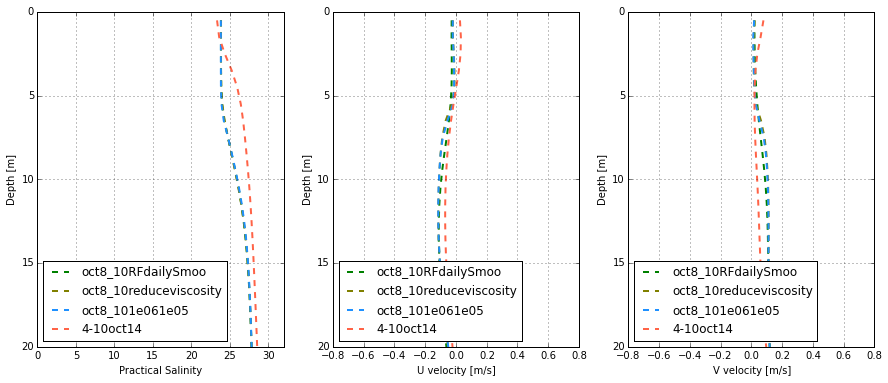

In [15]:
## python grid point (429, 290) for 29 hours,released at 16:00
buoy = 2
name, tracks=organize_info(buoy,ubc)
traj,jjj,iii,hour = plot_buoy_random(tracks, dt.datetime(2014,10,8), 8,22,i=-1, fancy=False)
# for particle
fig=plotoct_mewold(lon112,lat112,0,'7-Oct-2014','11-Oct-2014',8,10,8,16,0,29)
# for vertical profiles
fig = plot_salinity_uv(jjj,iii, hour,0, 20)

Released 2014-10-08 17:30:08.000004 at 49.1064116667 , -123.320053333 for 28.2499999981 hours
(datetime.datetime(2014, 10, 8, 19, 30, 7, 999997), -123.30016833333333, 49.12518166666667)
Random lat & lon in NEMO coords: 431 296


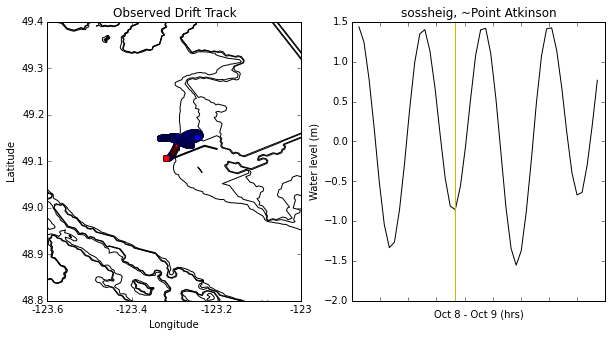

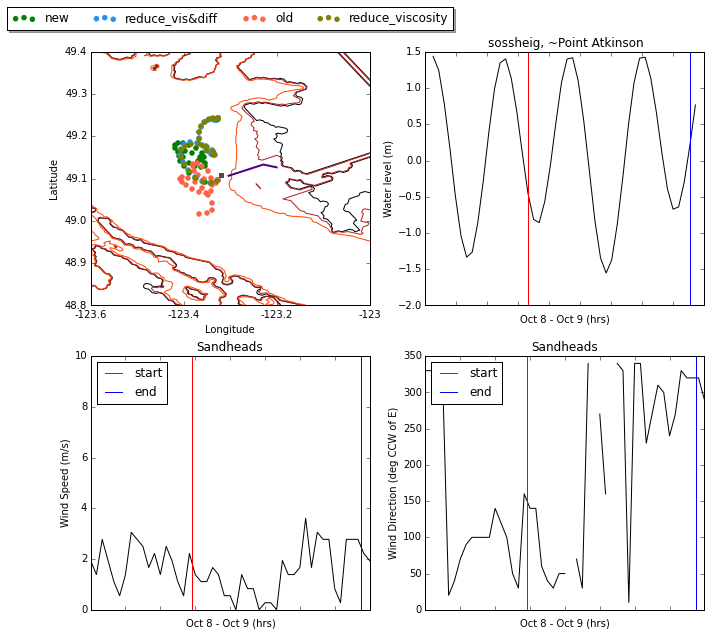

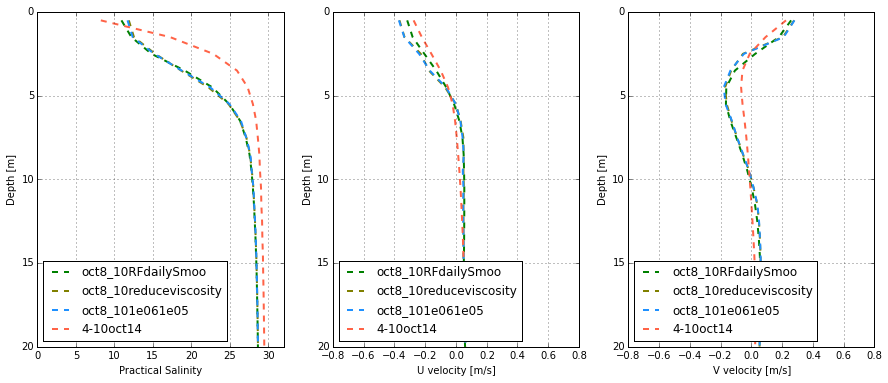

In [16]:
## python grid point (429,290) at 17:30 for 29hrs
buoy = 3
name, tracks=organize_info(buoy,ubc)
traj,jjj,iii,hour = plot_buoy_random(tracks, dt.datetime(2014,10,8), 8,19,i=-1, fancy=False)
fig=plotoct_mewold(lon112,lat112,1,'7-Oct-2014','11-Oct-2014',8,10,8,17,30,29)
fig = plot_salinity_uv(jjj,iii, hour,0, 20)

In [17]:
lon13={};lat13={}
o13 = nc.Dataset('/ocean/jieliu/research/meopar/Ariane/result/oct8_10RFdailySmoo/drop1/\
3/ariane_trajectories_qualitative.nc','r')
lon13['new']=o13.variables['traj_lon']
lat13['new']=o13.variables['traj_lat']
o13 = nc.Dataset('/ocean/jieliu/research/meopar/Ariane/result/oct8_10reduceviscosity/drop1/\
3/ariane_trajectories_qualitative.nc','r')
lon13['reduce_viscosity']=o13.variables['traj_lon']
lat13['reduce_viscosity']=o13.variables['traj_lat']
o13 = nc.Dataset('/ocean/jieliu/research/meopar/Ariane/result/oct8_101e061e05/drop1/\
3/ariane_trajectories_qualitative.nc','r')
lon13['reduce_vis&diff']=o13.variables['traj_lon']
lat13['reduce_vis&diff']=o13.variables['traj_lat']
o13 = nc.Dataset('/ocean/nsoontie/MEOPAR/Ariane/results/drifters/oct8/drop1/\
3/ariane_trajectories_qualitative.nc','r')
lon13['old']=o13.variables['traj_lon']
lat13['old']=o13.variables['traj_lat']

Released 2014-10-08 19:20:06.999998 at 49.1071733333 , -123.319563333 for 6.66666666611 hours
(datetime.datetime(2014, 10, 8, 19, 30, 7, 2), -123.31853666666666, 49.108548333333331)
Random lat & lon in NEMO coords: 429 291


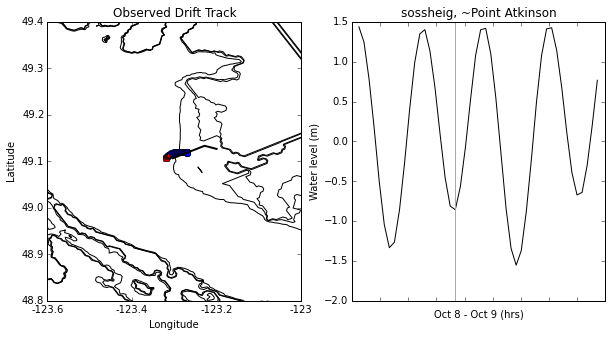

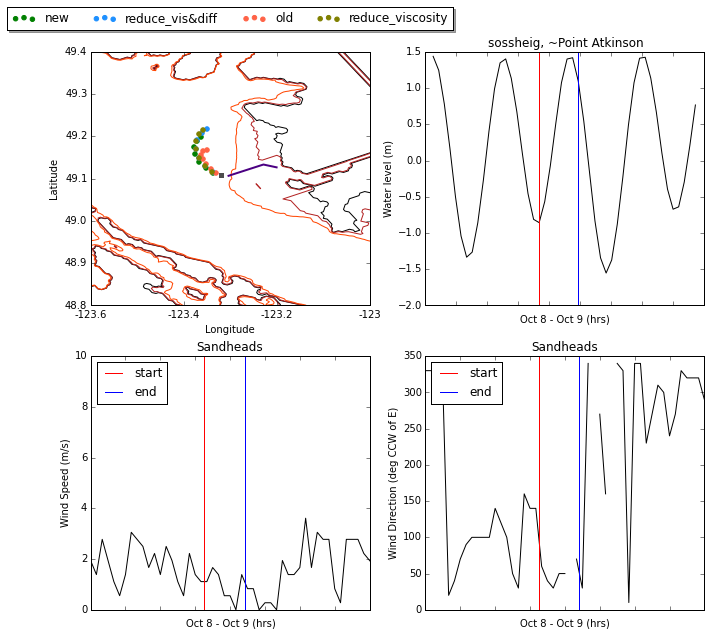

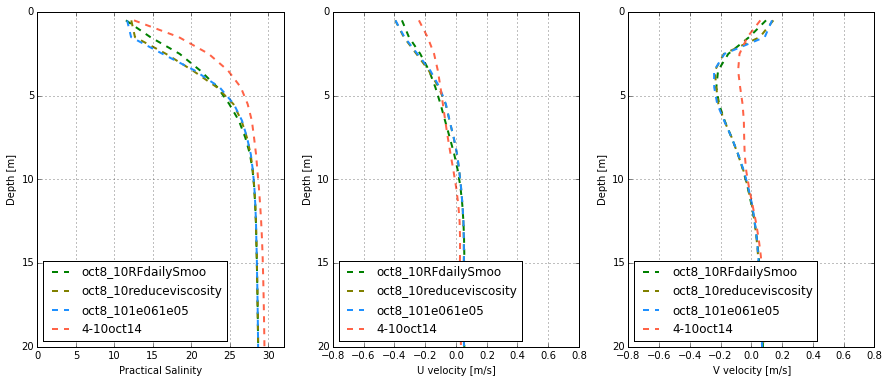

In [18]:
## python grid point (429,290) at 19:30 for 7hrs
buoy = 9
name, tracks=organize_info(buoy,ubc)
traj,jjj,iii,hour = plot_buoy_random(tracks, dt.datetime(2014,10,8), 8,19,i=-1, fancy=False)
name, tracks=organize_info(buoy,ubc)
fig=plotoct_mewold(lon13,lat13,0,'7-Oct-2014','11-Oct-2014',8,10,8,19,30,7)
fig = plot_salinity_uv(jjj,iii, hour,0, 20)

* Oct8 drop2

In [19]:
lon212={};lat212={}
o212 = nc.Dataset('/ocean/jieliu/research/meopar/Ariane/result/oct8_10RFdailySmoo/drop2/\
12/ariane_trajectories_qualitative.nc','r')
lon212['new']=o212.variables['traj_lon']
lat212['new']=o212.variables['traj_lat']
o212 = nc.Dataset('/ocean/jieliu/research/meopar/Ariane/result/oct8_10reduceviscosity/drop2/\
12/ariane_trajectories_qualitative.nc','r')
lon212['reduce_viscosity']=o212.variables['traj_lon']
lat212['reduce_viscosity']=o212.variables['traj_lat']
o212 = nc.Dataset('/ocean/jieliu/research/meopar/Ariane/result/oct8_101e061e05/drop2/\
12/ariane_trajectories_qualitative.nc','r')
lon212['reduce_vis&diff']=o212.variables['traj_lon']
lat212['reduce_vis&diff']=o212.variables['traj_lat']
o212 = nc.Dataset('/ocean/nsoontie/MEOPAR/Ariane/results/drifters/oct8/drop2/\
12/ariane_trajectories_qualitative.nc','r')
lon212['old']=o212.variables['traj_lon']
lat212['old']=o212.variables['traj_lat']

Released 2014-10-08 16:05:07.999996 at 49.0956433333 , -123.320643333 for 26.4997222228 hours
(datetime.datetime(2014, 10, 8, 18, 30, 8), -123.35801833333333, 49.049928333333334)
Random lat & lon in NEMO coords: 421 277


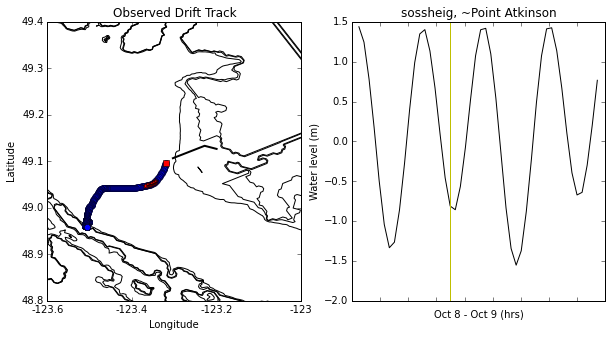

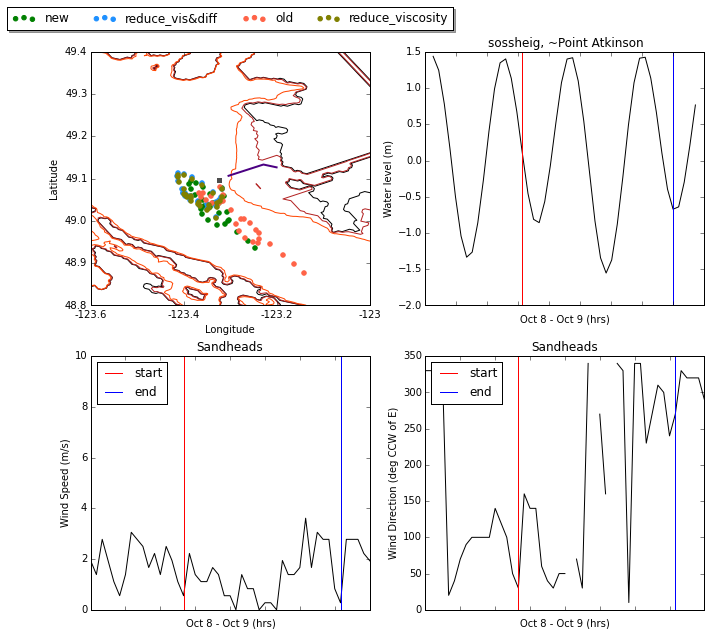

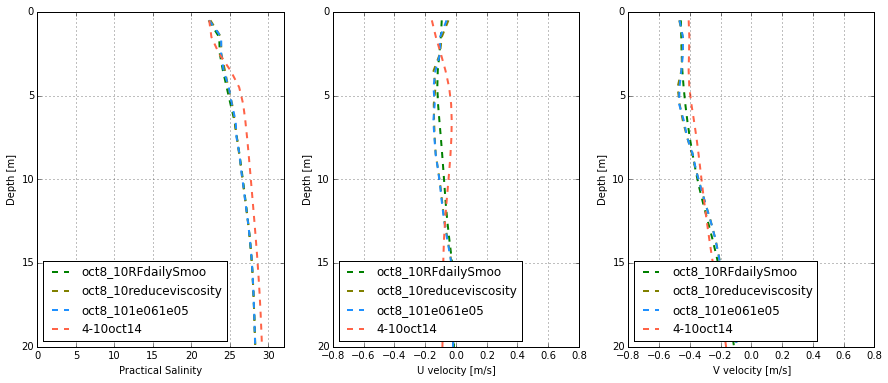

In [20]:
## python grid point (427,288) at 16:00 for 27hrs
buoy = 1
name, tracks=organize_info(buoy,ubc)
traj,jjj,iii,hour= plot_buoy_random(tracks, dt.datetime(2014,10,8), 8,18,i=-1, fancy=False)
fig = plotoct_mewold(lon212,lat212,0,'7-Oct-2014','11-Oct-2014',8,10,8,16,0,27)
fig = plot_salinity_uv(jjj,iii,hour,0, 20)

Released 2014-10-08 17:30:06.999999 at 49.0965066667 , -123.324513333 for 26.166944445 hours
(datetime.datetime(2014, 10, 8, 19, 30, 7, 2), -123.38970833333333, 49.083001666666668)
Random lat & lon in NEMO coords: 429 277


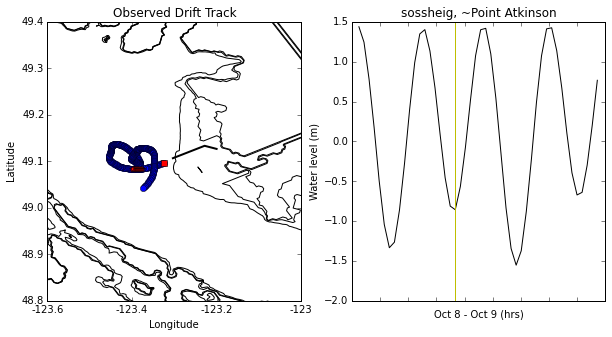

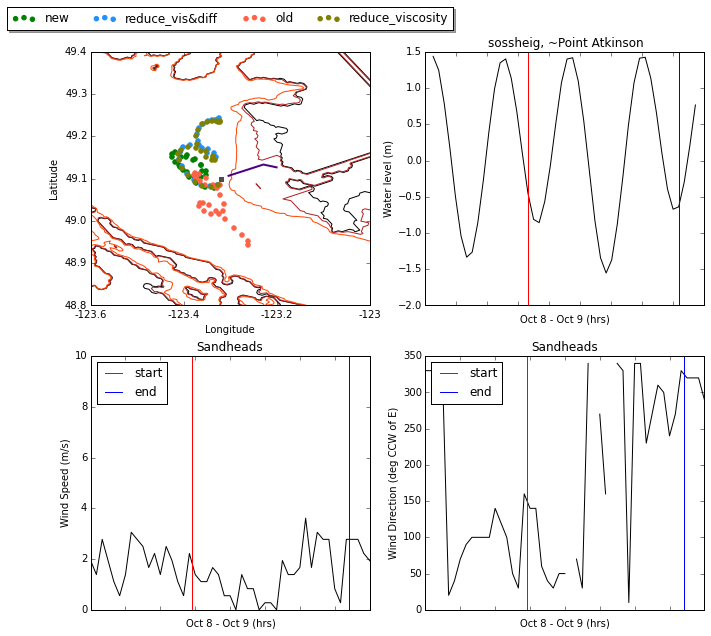

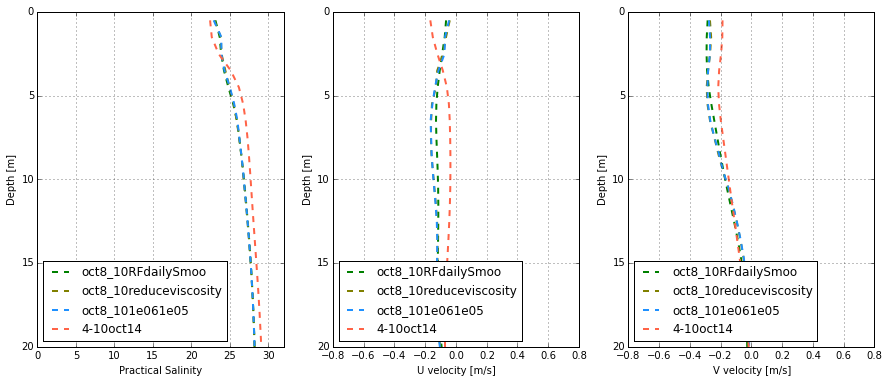

In [21]:
## python grid point (427,289) at 17:30 for 27hrs
buoy = 4
name, tracks=organize_info(buoy,ubc)
traj,jjj,iii,hour = plot_buoy_random(tracks, dt.datetime(2014,10,8), 8,19,i=-1, fancy=False)
fig = plotoct_mewold(lon212,lat212,1,'7-Oct-2014','11-Oct-2014',8,10,8,17,30,27)
fig = plot_salinity_uv(jjj,iii, hour,0, 20)

In [22]:
lon23={};lat23={}
o23 = nc.Dataset('/ocean/jieliu/research/meopar/Ariane/result/oct8_10RFdailySmoo/drop2/\
3/ariane_trajectories_qualitative.nc','r')
lon23['new']=o23.variables['traj_lon']
lat23['new']=o23.variables['traj_lat']
o23 = nc.Dataset('/ocean/jieliu/research/meopar/Ariane/result/oct8_10reduceviscosity/drop2/\
3/ariane_trajectories_qualitative.nc','r')
lon23['reduce_viscosity']=o23.variables['traj_lon']
lat23['reduce_viscosity']=o23.variables['traj_lat']
o23 = nc.Dataset('/ocean/jieliu/research/meopar/Ariane/result/oct8_101e061e05/drop2/\
3/ariane_trajectories_qualitative.nc','r')
lon23['reduce_vis&diff']=o23.variables['traj_lon']
lat23['reduce_vis&diff']=o23.variables['traj_lat']
o23 = nc.Dataset('/ocean/nsoontie/MEOPAR/Ariane/results/drifters/oct8/drop2/\
3/ariane_trajectories_qualitative.nc','r')
lon23['old']=o23.variables['traj_lon']
lat23['old']=o23.variables['traj_lat']

Released 2014-10-08 19:20:08.999997 at 49.0943266667 , -123.330828333 for 24.9163888889 hours
(datetime.datetime(2014, 10, 8, 20, 30, 8, 4), -123.37961333333334, 49.086148333333334)
Random lat & lon in NEMO coords: 429 279


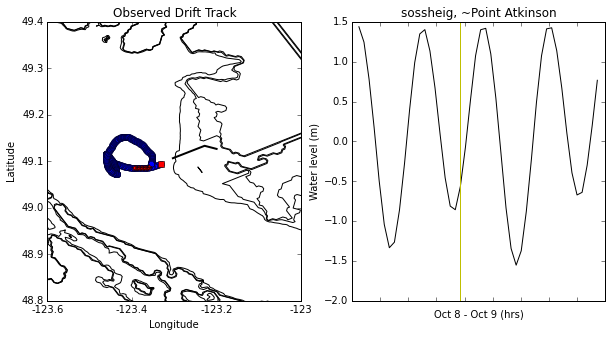

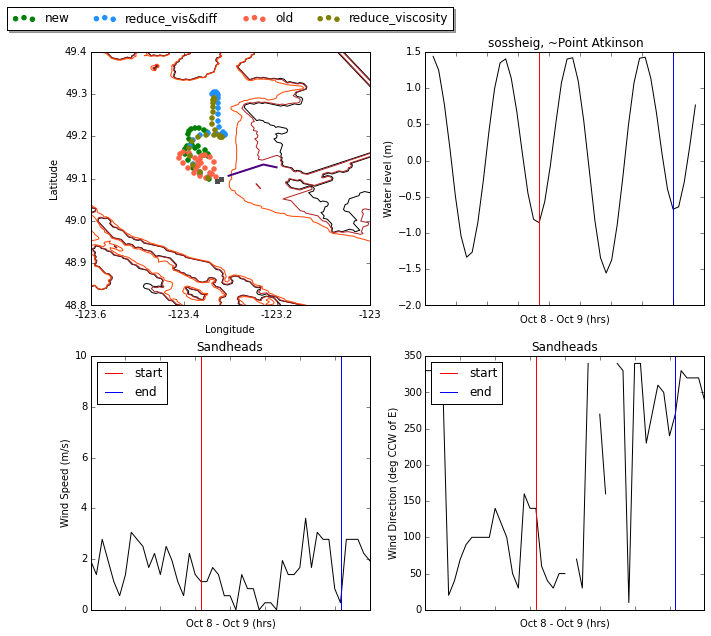

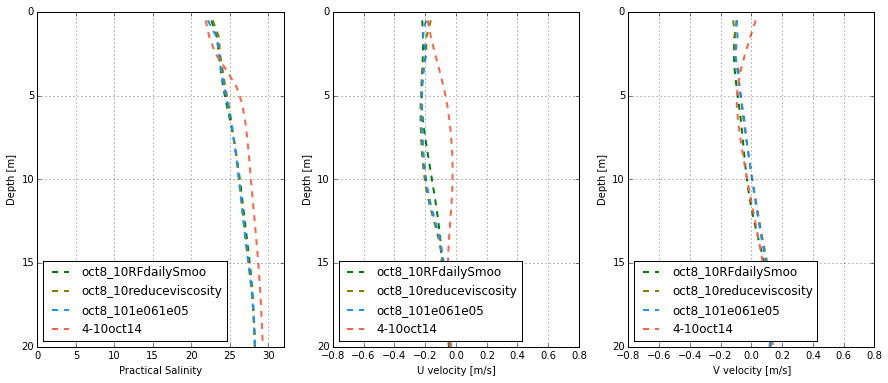

In [23]:
## python grid point (427,287) at 19:00 for 25hrs
buoy = 7
name, tracks=organize_info(buoy,ubc)
traj,jjj,iii,hour = plot_buoy_random(tracks, dt.datetime(2014,10,8), 8,20,i=-1, fancy=False)
fig = plotoct_mewold(lon23,lat23,0,'7-Oct-2014','11-Oct-2014',8,10,8,19,0,24)
fig = plot_salinity_uv(jjj,iii, hour,0, 20)

* Oct drop3

In [24]:
lon31={};lat31={}
o31 = nc.Dataset('/ocean/jieliu/research/meopar/Ariane/result/oct8_10RFdailySmoo/drop3/\
1/ariane_trajectories_qualitative.nc','r')
lon31['new']=o31.variables['traj_lon']
lat31['new']=o31.variables['traj_lat']
o31 = nc.Dataset('/ocean/jieliu/research/meopar/Ariane/result/oct8_10reduceviscosity/drop3/\
1/ariane_trajectories_qualitative.nc','r')
lon31['reduce_viscosity']=o31.variables['traj_lon']
lat31['reduce_viscosity']=o31.variables['traj_lat']
o31 = nc.Dataset('/ocean/jieliu/research/meopar/Ariane/result/oct8_101e061e05/drop3/\
1/ariane_trajectories_qualitative.nc','r')
lon31['reduce_vis&diff']=o31.variables['traj_lon']
lat31['reduce_vis&diff']=o31.variables['traj_lat']
o31 = nc.Dataset('/ocean/nsoontie/MEOPAR/Ariane/results/drifters/oct8/drop3/\
1/ariane_trajectories_qualitative.nc','r')
lon31['old']=o31.variables['traj_lon']
lat31['old']=o31.variables['traj_lat']

Released 2014-10-08 16:00:06.999999 at 49.0862766667 , -123.320955 for 26.5002777781 hours
(datetime.datetime(2014, 10, 8, 20, 30, 6, 999999), -123.41076833333334, 49.035786666666667)
Random lat & lon in NEMO coords: 422 268


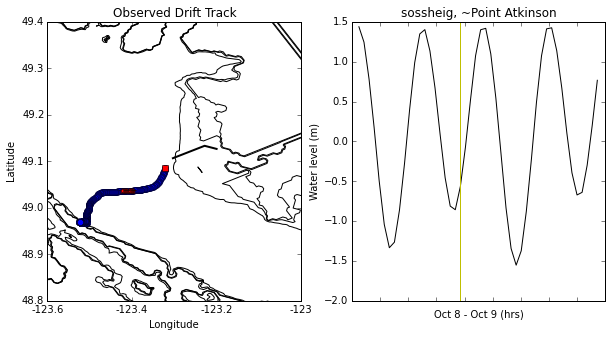

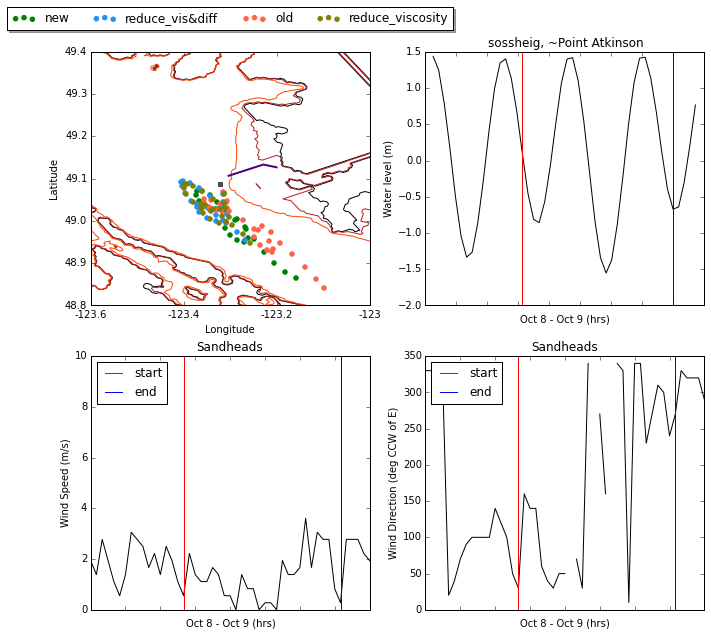

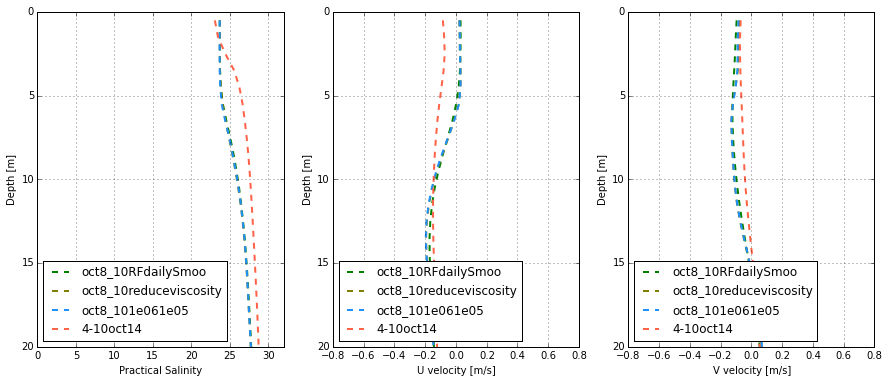

In [25]:
## python grid point (425,287) at 16:00 for 27hrs
buoy = 0
name, tracks=organize_info(buoy,ubc)
traj,jjj,iii,hour = plot_buoy_random(tracks, dt.datetime(2014,10,8), 8,20,i=-1, fancy=False)
fig = plotoct_mewold(lon31,lat31,0,'7-Oct-2014','11-Oct-2014',8,10,8,16,0,27)
fig = plot_salinity_uv(jjj,iii,hour,0, 20)

In [26]:
lon323={};lat323={}
o323 = nc.Dataset('/ocean/jieliu/research/meopar/Ariane/result/oct8_10RFdailySmoo/drop3/\
23/ariane_trajectories_qualitative.nc','r')
lon323['new']=o323.variables['traj_lon']
lat323['new']=o323.variables['traj_lat']
o323 = nc.Dataset('/ocean/jieliu/research/meopar/Ariane/result/oct8_10reduceviscosity/drop3/\
23/ariane_trajectories_qualitative.nc','r')
lon323['reduce_viscosity']=o323.variables['traj_lon']
lat323['reduce_viscosity']=o323.variables['traj_lat']
o323 = nc.Dataset('/ocean/jieliu/research/meopar/Ariane/result/oct8_101e061e05/drop3/\
23/ariane_trajectories_qualitative.nc','r')
lon323['reduce_vis&diff']=o323.variables['traj_lon']
lat323['reduce_vis&diff']=o323.variables['traj_lat']
o323 = nc.Dataset('/ocean/nsoontie/MEOPAR/Ariane/results/drifters/oct8/drop3/\
23/ariane_trajectories_qualitative.nc','r')
lon323['old']=o323.variables['traj_lon']
lat323['old']=o323.variables['traj_lat']

Released 2014-10-08 17:35:07.000001 at 49.08599 , -123.323693333 for 23.8333333322 hours
(datetime.datetime(2014, 10, 8, 20, 30, 8, 4), -123.45084666666666, 49.04448166666667)
Random lat & lon in NEMO coords: 426 263


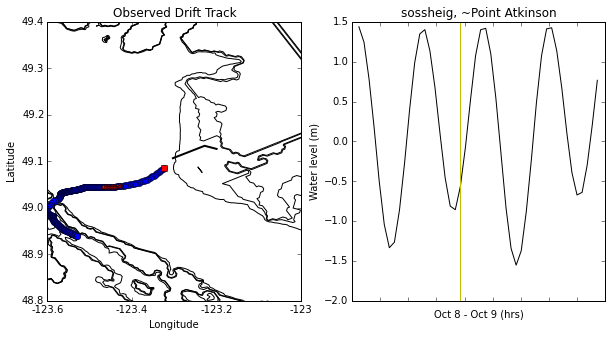

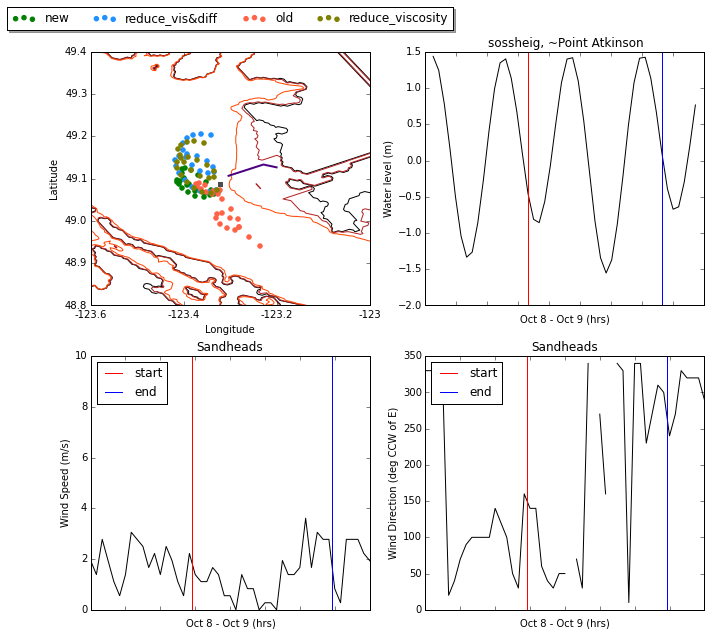

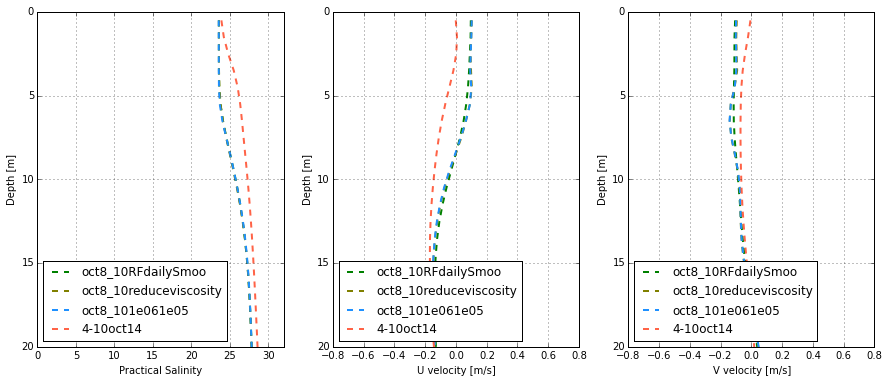

In [27]:
## python grid point (425,287) at 17:30 for 24hrs
buoy = 5
name, tracks=organize_info(buoy,ubc)
traj,jjj,iii,hour = plot_buoy_random(tracks, dt.datetime(2014,10,8), 8,20,i=-1, fancy=False)
fig = plotoct_mewold(lon323,lat323,0,'7-Oct-2014','11-Oct-2014',8,10,8,17,30,24)
fig = plot_salinity_uv(jjj,iii,hour,0, 20)

Released 2014-10-08 19:10:07.999998 at 49.0856266667 , -123.325655 for 23.0836111111 hours
(datetime.datetime(2014, 10, 8, 23, 30, 8, 4), -123.47169166666667, 49.062736666666666)
Random lat & lon in NEMO coords: 431 263


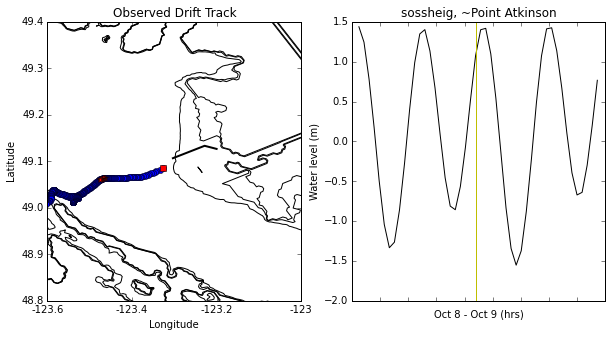

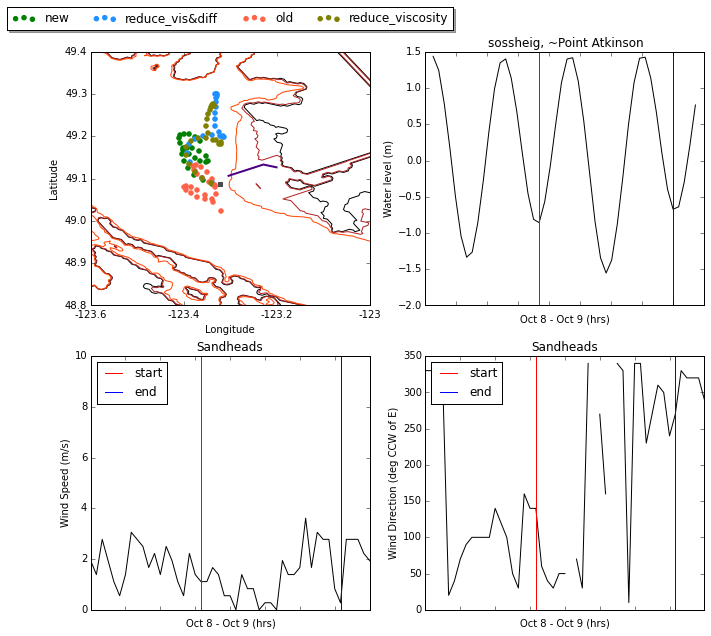

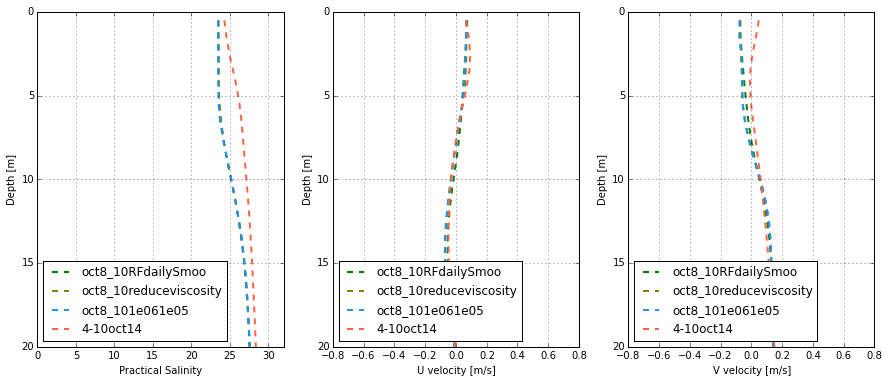

In [28]:
## python grid point (425,287) at 19:00 for 24hrs
buoy = 6
name, tracks=organize_info(buoy,ubc)
traj,jjj,iii,hour = plot_buoy_random(tracks, dt.datetime(2014,10,8), 8,23,i=-1, fancy=False)
fig = plotoct_mewold(lon323,lat323,1,'7-Oct-2014','11-Oct-2014',8,10,8,19,0,24)
fig = plot_salinity_uv(jjj,iii, hour,0, 20)

* Overall, results with new river treatments are better than nowcasts except drop23. But the problem with new river is we have too much plume going northward! Does it due to lack of jetty?

* 